In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages', '/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing/notebooks']); import pickle; snakemake = pickle.loads(b'\x80\x04\x95\xb8"\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c.data/flu_sequences/pacbio_amplicons/fluCA09.gb\x94\x8c9data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml\x94\x8c[results/pacbio/scProgenyProduction_trial3_2021-08-05_all_segments_run1_ccs_fixterm.fastq.gz\x94\x8c[results/pacbio/scProgenyProduction_trial3_2021-09-17_all_segments_run2_ccs_fixterm.fastq.gz\x94\x8cQresults/pacbio/scProgenyProduction_trial3_2021-08-05_all_segments_run1_report.txt\x94\x8cQresults/pacbio/scProgenyProduction_trial3_2021-09-17_all_segments_run2_report.txt\x94\x8c=data/flu_sequences/pacbio_amplicons/amplicon_to_reference.csv\x94\x8c\x1fnotebooks/align_pacbio.py.ipynb\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\tamplicons\x94K\x00N\x86\x94\x8c\x08features\x94K\x01N\x86\x94\x8c\tccs_fastq\x94K\x02K\x04\x86\x94\x8c\nccs_report\x94K\x04K\x06\x86\x94\x8c\x18amplicon_to_reference_df\x94K\x06N\x86\x94\x8c\x08notebook\x94K\x07N\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh#\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h))}\x94\x8c\x05_name\x94h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94bh\x15h\nh\x17h\x0bh\x19h\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\x0ch\re}\x94(h\x13}\x94h!]\x94(h#h$eh#h\'h)\x85\x94R\x94(h))}\x94h-h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94bubh\x1bh4)\x81\x94(h\x0eh\x0fe}\x94(h\x13}\x94h!]\x94(h#h$eh#h\'h)\x85\x94R\x94(h))}\x94h-h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94bubh\x1dh\x10h\x1fh\x11ub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8c7results/pacbio/scProgenyProduction_trial3_amplicons.svg\x94\x8cGresults/pacbio/scProgenyProduction_trial3_pacbio_passing_alignments.svg\x94\x8cAresults/pacbio/scProgenyProduction_trial3_mutations_by_ccs.csv.gz\x94e}\x94(h\x13}\x94(\x8c\x0eplot_amplicons\x94K\x00N\x86\x94\x8c\x0eplot_alignment\x94K\x01N\x86\x94\x8c\x0bmutation_df\x94K\x02N\x86\x94uh!]\x94(h#h$eh#h\'h)\x85\x94R\x94(h))}\x94h-h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94bhVhQhXhRhZhSub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(]\x94(\x8c7scProgenyProduction_trial3_2021-08-05_all_segments_run1\x94\x8c7scProgenyProduction_trial3_2021-09-17_all_segments_run2\x94e\x8c>results/pacbio/CA09_align_and_parse/scProgenyProduction_trial3\x94e}\x94(h\x13}\x94(\x8c\x04runs\x94K\x00N\x86\x94\x8c\x0falignment_stats\x94K\x01N\x86\x94uh!]\x94(h#h$eh#h\'h)\x85\x94R\x94(h))}\x94h-h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94bhohihqhlub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94\x8c\x1ascProgenyProduction_trial3\x94a}\x94(h\x13}\x94\x8c\x04expt\x94K\x00N\x86\x94sh!]\x94(h#h$eh#h\'h)\x85\x94R\x94(h))}\x94h-h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94b\x8c\x04expt\x94h\x80ub\x8c\x07threads\x94K\x10\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x10K\x01e}\x94(h\x13}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94uh!]\x94(h#h$eh#h\'h)\x85\x94R\x94(h))}\x94h-h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94bh\x96K\x10h\x98K\x01ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c:results/logs/align_pacbio_scProgenyProduction_trial3.ipynb\x94a}\x94(h\x13}\x94h\x1fK\x00N\x86\x94sh!]\x94(h#h$eh#h\'h)\x85\x94R\x94(h))}\x94h-h#sNt\x94bh$h\'h)\x85\x94R\x94(h))}\x94h-h$sNt\x94bh\x1fh\xa7ub\x8c\x06config\x94}\x94(\x8c\x08max_cpus\x94K\x10\x8c\x07log_dir\x94\x8c\x0cresults/logs\x94\x8c\x0cfastq10x_dir\x94\x8c\x10results/fastq10x\x94\x8c\npacbio_dir\x94\x8c\x0eresults/pacbio\x94\x8c\x0emkfastq10x_dir\x94\x8c\x1fresults/fastq10x/mkfastq_output\x94\x8c\ngenome_dir\x94\x8c\x0fresults/genomes\x94\x8c\trefgenome\x94\x8c\x19results/genomes/refgenome\x94\x8c\x14aligned_fastq10x_dir\x94\x8c\x18results/aligned_fastq10x\x94\x8c\x12viral_fastq10x_dir\x94\x8c\x16results/viral_fastq10x\x94\x8c\x1bviral_tags_bcs_in_cells_dir\x94\x8c\x1fresults/viral_tags_bcs_in_cells\x94\x8c\x11viral_progeny_dir\x94\x8c\x15results/viral_progeny\x94\x8c\x13align_and_parse_dir\x94\x8c#results/pacbio/CA09_align_and_parse\x94\x8c\x0fcell_genome_ftp\x94\x8cmftp://ftp.ensembl.org/pub/release-98/fasta/canis_familiaris/dna/Canis_familiaris.CanFam3.1.dna.toplevel.fa.gz\x94\x8c\x0ccell_gtf_ftp\x94\x8c^ftp://ftp.ensembl.org/pub/release-98/gtf/canis_familiaris/Canis_familiaris.CanFam3.1.98.gtf.gz\x94\x8c\x0cviral_genome\x94\x8c!data/flu_sequences/flu-CA09.fasta\x94\x8c\tviral_gtf\x94\x8c\x1fdata/flu_sequences/flu-CA09.gtf\x94\x8c\rviral_genbank\x94\x8c\x1edata/flu_sequences/flu-CA09.gb\x94\x8c\x14viral_tag_identities\x94\x8c+data/flu_sequences/flu-CA09_viral_tags.yaml\x94\x8c\x0fviral_amplicons\x94\x8c.data/flu_sequences/pacbio_amplicons/fluCA09.gb\x94\x8c\x11amplicon_features\x94\x8c9data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml\x94\x8c\x1eamplicon_linearization_primers\x94\x8c=data/flu_sequences/pacbio_amplicons/linearization_primers.tsv\x94\x8c\x15amplicon_to_reference\x94\x8c=data/flu_sequences/pacbio_amplicons/amplicon_to_reference.csv\x94\x8c\x0escoreGapNoncan\x94J\xfc\xff\xff\xff\x8c\x0cscoreGapGCAG\x94J\xfc\xff\xff\xff\x8c\x0cscoreGapATAC\x94J\xfc\xff\xff\xff\x8c\x14cb_whitelist_10x_url\x94\x8cvhttps://raw.githubusercontent.com/10XGenomics/cellranger/master/lib/python/cellranger/barcodes/3M-february-2018.txt.gz\x94\x8c\x10cb_whitelist_10x\x94\x8c-results/aligned_fastq10x/cb_whitelist_10x.txt\x94\x8c\ncb_len_10x\x94K\x10\x8c\x0bumi_len_10x\x94K\x0c\x8c\x14total_UMI_deviations\x94G@\x04\x00\x00\x00\x00\x00\x00\x8c\x13infection_threshold\x94G?\x84z\xe1G\xae\x14{\x8c\rviral_tag_fdr\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x1dviral_barcode_upstream_length\x94K\x1c\x8c\x16viral_barcode_mismatch\x94K\x00\x8c\x12viral_barcode_minq\x94K\x1e\x8c\x17progeny_detection_limit\x94\x8c\x041e-5\x94\x8c\x0cviral_bc_fdr\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x0eccs_min_length\x94K2\x8c\x0eccs_max_length\x94M\x88\x13\x8c\nccs_min_rq\x94G?\xef\xf7\xce\xd9\x16\x87+\x8c\x0bexperiments\x94}\x94\x8c\x1ascProgenyProduction_trial3\x94}\x94(\x8c\x0bdescription\x94X\x1b\x01\x00\x00Single-cell transcriptomics performed on even lower MOI-infected sample. Innoculum volumes based on `scProgenyProduction_trial1` and `scProgenyProduction_trial2` data. Loaded all collected cells from two 24-well wells, each infected with either wildtype or dblySn viral tag variants.\x94\x8c\tlab_notes\x94\x8c0https://benchling.com/s/etr-N4laiIAy3AUePJdig7wR\x94\x8c\rexpect_ncells\x94M\x10\'\x8c\x0ftranscriptomics\x94}\x94(\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe5\x03\x0c\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8c_/shared/ngs/illumina/bloom_lab/210312_D00300_1192_BHKHNYBCX3/raw/210312_D00300_1192_BHKHNYBCX3/\x94\x8c\x04lane\x94K\x01\x8c\x10index_sequencing\x94\x8c\x06single\x94uj\x03\x01\x00\x00C\x04\x07\xe5\x04\t\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8c_/shared/ngs/illumina/bloom_lab/210409_D00300_1210_BHKC7KBCX3/raw/210409_D00300_1210_BHKC7KBCX3/\x94\x8c\x04lane\x94\x8c\x01*\x94\x8c\x10index_sequencing\x94\x8c\x06single\x94uj\x03\x01\x00\x00C\x04\x07\xe5\x08\x19\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8c_/shared/ngs/illumina/bloom_lab/210825_D00300_1310_BHMH5TBCX3/raw/210825_D00300_1310_BHMH5TBCX3/\x94\x8c\x04lane\x94j\x18\x01\x00\x00\x8c\x10index_sequencing\x94\x8c\x04none\x94uj\x03\x01\x00\x00C\x04\x07\xe5\t\x0f\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8cY/shared/ngs/illumina/bloom_lab/210915_VH00699_2_AAAMCL7M5/raw/210915_VH00699_2_AAAMCL7M5/\x94\x8c\x04lane\x94j\x18\x01\x00\x00\x8c\x10index_sequencing\x94\x8c\x04none\x94uu\x8c\x17pacbio_viral_sequencing\x94}\x94(\x8c\x1c2021-08-05_all_segments_run1\x94\x8cp/fh/fast/bloom_j/SR/ngs/pacbio/210730_SequelIIe/r64272e_20210730_182729/1_A01/m64272e_210730_193026.subreads.bam\x94\x8c\x1c2021-09-17_all_segments_run2\x94\x8cp/fh/fast/bloom_j/SR/ngs/pacbio/210917_SequelIIe/r64272e_20210917_174421/1_A01/m64272e_210917_175514.subreads.bam\x94u\x8c\x0eviral_barcodes\x94}\x94(\x8c\x0bsupernatant\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/WT-sup-fluHA-rep1_S9_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/WT-sup-fluHA-rep2_S13_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/WT-sup-fluNA-rep1_S1_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x86/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-sup-fluNA-rep2_S1_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluHA-rep1_S10_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluHA-rep2_S14_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x94/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluNA-rep1_S2_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x94/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluNA-rep2_S6_L001_R1_001.fastq.gz\x94suuu\x8c\x10second_infection\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x85/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluHA-rep1_S2_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x85/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluHA-rep2_S3_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x86/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluNA-rep1_S11_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x86/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluNA-rep2_S12_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x89/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluHA-rep1_S4_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x89/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluHA-rep2_S5_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x8a/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluNA-rep1_S13_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94j\x03\x01\x00\x00C\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x8a/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluNA-rep2_S14_L001_R1_001.fastq.gz\x94suuuuusu\x8c\x04rule\x94\x8c\x0calign_pacbio\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c[/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing/notebooks\x94ub.'); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir('/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing');
######## snakemake preamble end #########


# Align and call mutations in PacBio sequencing of viral genes.

This Python Jupyter notebook aligns the PacBio sequencing of the viral genes, calls mutations, and then puts them in numbering based on the viral ORF.

In [2]:
import os
import warnings

from IPython.display import HTML, display

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
import alignparse.utils
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

import pandas as pd

import plotnine as p9

In [3]:
warnings.simplefilter('ignore')

In [4]:
p9.theme_set(dms_variants.plotnine_themes.theme_graygrid())

Import snakemake variables

In [5]:
amplicons = snakemake.input.amplicons
features = snakemake.input.features
plot_amplicons = snakemake.output.plot_amplicons
plot_alignment = snakemake.output.plot_alignment
ccs_report = snakemake.input.ccs_report
ccs_fastq = snakemake.input.ccs_fastq
runs = snakemake.params.runs
amplicon_to_reference_df = snakemake.input.amplicon_to_reference_df
alignment_stats = snakemake.params.alignment_stats
mutation_df = snakemake.output.mutation_df
threads = snakemake.threads

## Import target amplicons
Here we import target files for amplicons that where made using primers that either aligned to ends of flu sequences ('termini') or primers aligning approximately to the middle of a gene ('mid').

In [ ]:
targetfile = amplicons

nlines_to_show = 100
with open(targetfile) as f:
    print(''.join(next(f) for _ in range(nlines_to_show)))

Feature file defines features in amplicon genbank file.

In [ ]:
feature_parse_specs_file = features
with open(feature_parse_specs_file) as f:
    print(f.read())

In [ ]:
targets = alignparse.targets.Targets(
                seqsfile=targetfile,
                feature_parse_specs=feature_parse_specs_file,
                ignore_feature_parse_specs_keys=['default_2tags_no_parsed_ORF_2',
                                                 'default_2tags',
                                                 'default_8tags'],
                allow_extra_features=True,
                allow_clipped_muts_seqs=True)

Now let's plot all transcript amplicons and save plots as a figure. 

In [ ]:
plot = targets.plot(ax_width=10)

In [ ]:
print(f"Saving figure to {plot_amplicons}")
plot.savefig(plot_amplicons, format="svg")

## Align pacbio reads

Create pacbio run dataframe

In [ ]:
pacbio_runs = pd.DataFrame(
    {'name': runs, 'fastq': ccs_fastq, 'report': ccs_report}
)
display(HTML(pacbio_runs.to_html(index=False)))

Now align all ccs to amplicons and filter for the ones that meet criteria defined in `fluCA09_features.yaml`.

Create an alignparse.minimap2.Mapper to run minimap2 with minimap [options](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.OPTIONS_VIRUS_W_DEL) that allow for large deletions in viral sequences. 

In [ ]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_VIRUS_W_DEL)

print(f"Using `minimap2` {mapper.version} with these options:\n"
      + ' '.join(mapper.options))

In [ ]:
align_and_parse_outdir = os.path.join(alignment_stats)

In [ ]:
readstats, aligned, filtered = targets.align_and_parse(
    df=pacbio_runs,
    mapper=mapper,
    outdir=align_and_parse_outdir,
    name_col='name',
    queryfile_col='fastq',
    overwrite=True,  # overwrite any existing output
    to_csv=True,
    ncpus=threads,
)

Save readstats to CSV for future reference.

In [ ]:
readstats.to_csv('readstats.csv')

In [6]:
readstats = pd.read_csv('readstats.csv')

Here are read alignment statistics telling how many reads have been aligned or filtered out for each reference amplicon.

In [7]:
readstats.head()

,Unnamed: 0,name,category,count
0,0,scProgenyProduction_trial3_2021-08-05_all_segm...,filtered NPmid,38178
1,1,scProgenyProduction_trial3_2021-08-05_all_segm...,aligned NPmid,142162
2,2,scProgenyProduction_trial3_2021-08-05_all_segm...,filtered PAtermini,23761
3,3,scProgenyProduction_trial3_2021-08-05_all_segm...,aligned PAtermini,37482
4,4,scProgenyProduction_trial3_2021-08-05_all_segm...,filtered PAmid,5728


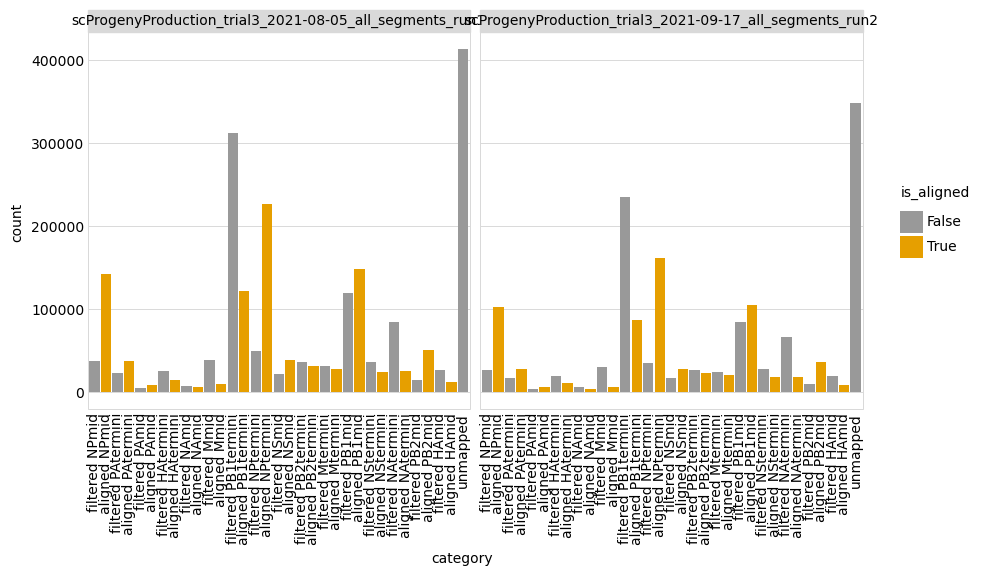

In [8]:
p = (
    p9.ggplot(readstats.assign(
        category=lambda x: pd.Categorical(x['category'],
                                          x['category'].unique(),
                                          ordered=True),
        is_aligned=lambda x: x['category'].str.contains('aligned'),),
        p9.aes('category', 'count', fill='is_aligned'))
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('~ name', nrow=1)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank(),
               figure_size=(10, 5),
               )
    + p9.scale_fill_manual(values=CBPALETTE)
)
_ = p.draw()

p9.ggsave(plot=p, filename=plot_alignment, verbose=False)

Group counts by gene across runs. Plot fraction filtered/aligned:

In [9]:
readstats[['filtered','gene']] = readstats['category'].str.split(' ', expand=True)

In [11]:
readstats['count_gene'] = readstats.groupby(['filtered','gene'])['count'].transform('sum')
readstats['total_gene'] = readstats.groupby(['gene'])['count'].transform('sum')
readstats['frac'] = readstats['count_gene'] / readstats['total_gene']
readstats.head()

,Unnamed: 0,name,category,count,filtered,gene,count_gene,total_gene,frac
0,0,scProgenyProduction_trial3_2021-08-05_all_segm...,filtered NPmid,38178,filtered,NPmid,65233.0,310624.0,0.210006
1,1,scProgenyProduction_trial3_2021-08-05_all_segm...,aligned NPmid,142162,aligned,NPmid,245391.0,310624.0,0.789994
2,2,scProgenyProduction_trial3_2021-08-05_all_segm...,filtered PAtermini,23761,filtered,PAtermini,41279.0,106301.0,0.388322
3,3,scProgenyProduction_trial3_2021-08-05_all_segm...,aligned PAtermini,37482,aligned,PAtermini,65022.0,106301.0,0.611678
4,4,scProgenyProduction_trial3_2021-08-05_all_segm...,filtered PAmid,5728,filtered,PAmid,9756.0,25562.0,0.381660


Save fractions to CSV:

In [44]:
readstats[['gene', 'filtered', 'count', 'total_gene', 'frac']].to_csv('filtered_by_gene.csv')

Plot normalized fractions:

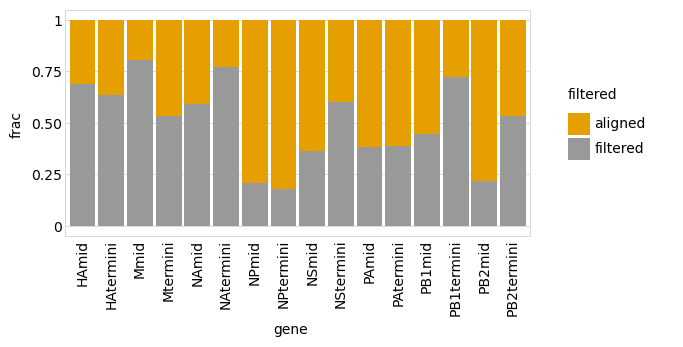

In [22]:
p = (
    p9.ggplot((readstats
               [['filtered','gene','frac']]
               .drop_duplicates()
               .query('filtered != "unmapped"')),
        p9.aes('gene', 'frac', fill='filtered'))
    + p9.geom_bar(stat='identity')
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank(),
               figure_size=(6, 3),
               )
    + p9.scale_fill_manual(values=[CBPALETTE[1],CBPALETTE[0]])
)
_ = p.draw()

Now lets look at the most common reasons why some reads have been filtered out.

In [ ]:
concatenated_ff_df = pd.DataFrame()
for filtered_file in filtered:
    ff = pd.read_csv(filtered[filtered_file], na_filter=False)
    ff['gene'] = filtered_file
    concatenated_ff_df = pd.concat([concatenated_ff_df, ff], axis=0)

Save concatenated_ff_df to CSV for future reference:

In [23]:
concatenated_ff_df.to_csv('concatenated_ff_df.csv')

NameError: name 'concatenated_ff_df' is not defined

In [26]:
concatenated_ff_df = pd.read_csv('concatenated_ff_df.csv')

In [28]:
concatenated_ff_df.head()

,Unnamed: 0,name,query_name,filter_reason,gene
0,0,scProgenyProduction_trial3_2021-08-05_all_segm...,m64272e_210730_193026/326/ccs,primer_site_2 clip3,NPmid
1,1,scProgenyProduction_trial3_2021-08-05_all_segm...,m64272e_210730_193026/444/ccs,UMI mutation_nt_count,NPmid
2,2,scProgenyProduction_trial3_2021-08-05_all_segm...,m64272e_210730_193026/527/ccs,parsed_termini3 mutation_nt_count,NPmid
3,3,scProgenyProduction_trial3_2021-08-05_all_segm...,m64272e_210730_193026/806/ccs,primer_site_2 clip3,NPmid
4,4,scProgenyProduction_trial3_2021-08-05_all_segm...,m64272e_210730_193026/961/ccs,query_clip5,NPmid


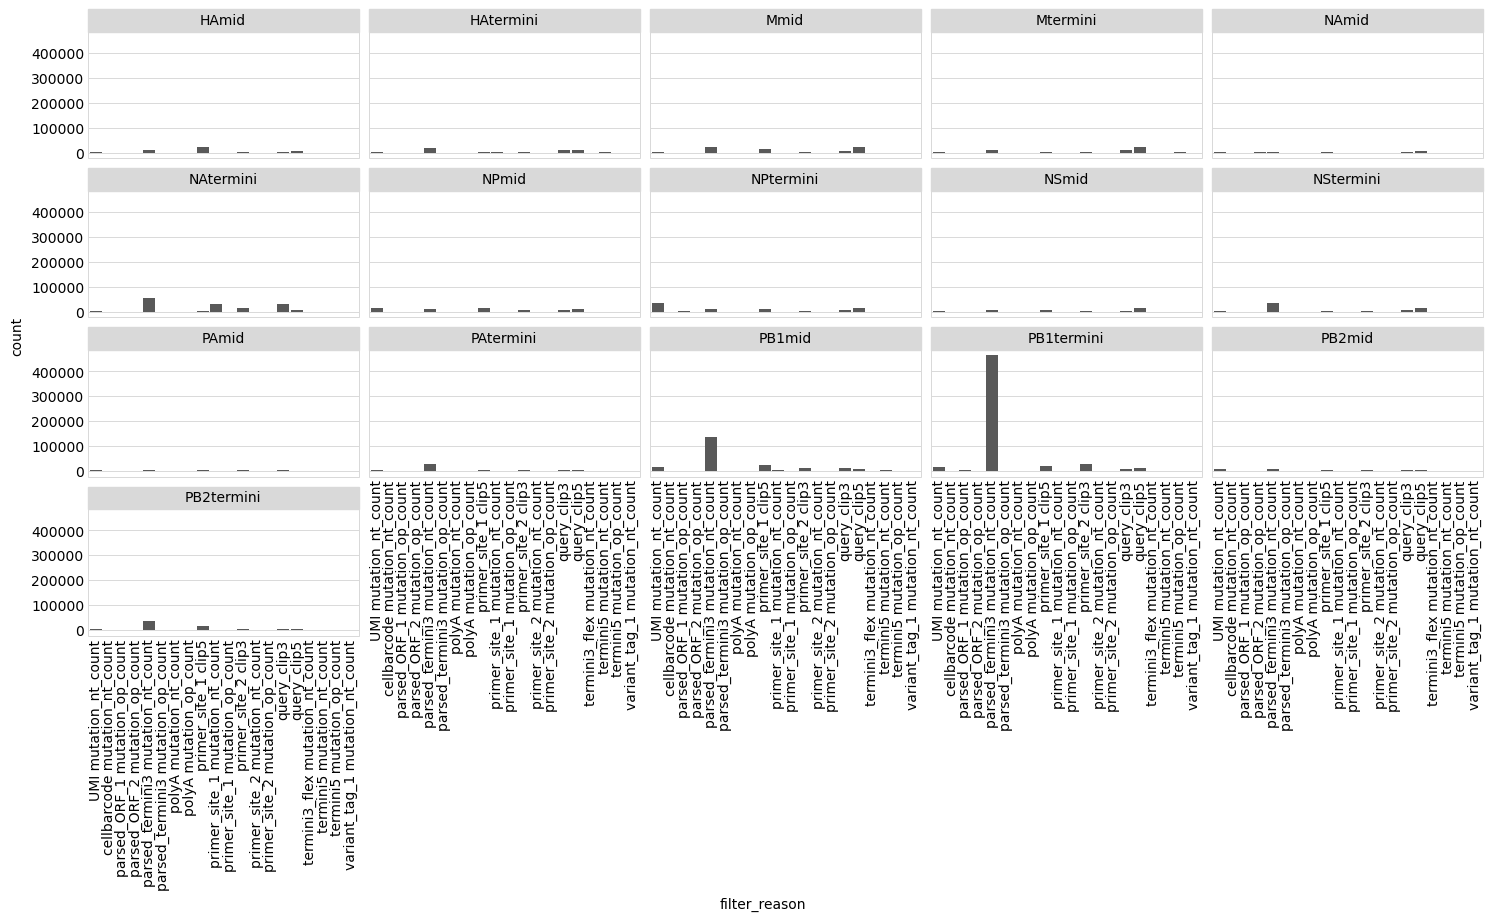

In [27]:
p = (
    p9.ggplot(concatenated_ff_df, p9.aes('filter_reason'))
    + p9.geom_bar()
    + p9.facet_wrap('~ gene', ncol=5)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               figure_size=(18, 8),
               panel_grid_major_x=p9.element_blank(),
               )
    )
_ = p.draw()

Count number of CCS filtered for each gene. Count number of CCS filtered for each reason.

In [42]:
ff_counts_df = (
    concatenated_ff_df
    .groupby(['gene','filter_reason'])
    .count()
    .reset_index()
    .rename(columns={'name':'count'})
    [['gene','filter_reason','count']])
ff_counts_df['total_gene'] = ff_counts_df.groupby(['gene'])['count'].transform('sum')
ff_counts_df['frac_filtered_reason'] = ff_counts_df['count'] / ff_counts_df['total_gene']
display(ff_counts_df)

,gene,filter_reason,count,total_gene,frac_filtered_reason
0,HAmid,UMI mutation_nt_count,1079,47097,0.022910
1,HAmid,cellbarcode mutation_nt_count,2,47097,0.000042
2,HAmid,parsed_ORF_1 mutation_op_count,12,47097,0.000255
3,HAmid,parsed_ORF_2 mutation_op_count,8,47097,0.000170
4,HAmid,parsed_termini3 mutation_nt_count,10985,47097,0.233242
...,...,...,...,...,...
274,PB2termini,query_clip3,2203,63498,0.034694
275,PB2termini,query_clip5,3388,63498,0.053356
276,PB2termini,termini3_flex mutation_nt_count,38,63498,0.000598
277,PB2termini,termini5 mutation_nt_count,102,63498,0.001606


Save fractions to CSV:

In [43]:
ff_counts_df.to_csv('filtered_reasons.csv')

Plot fraction:

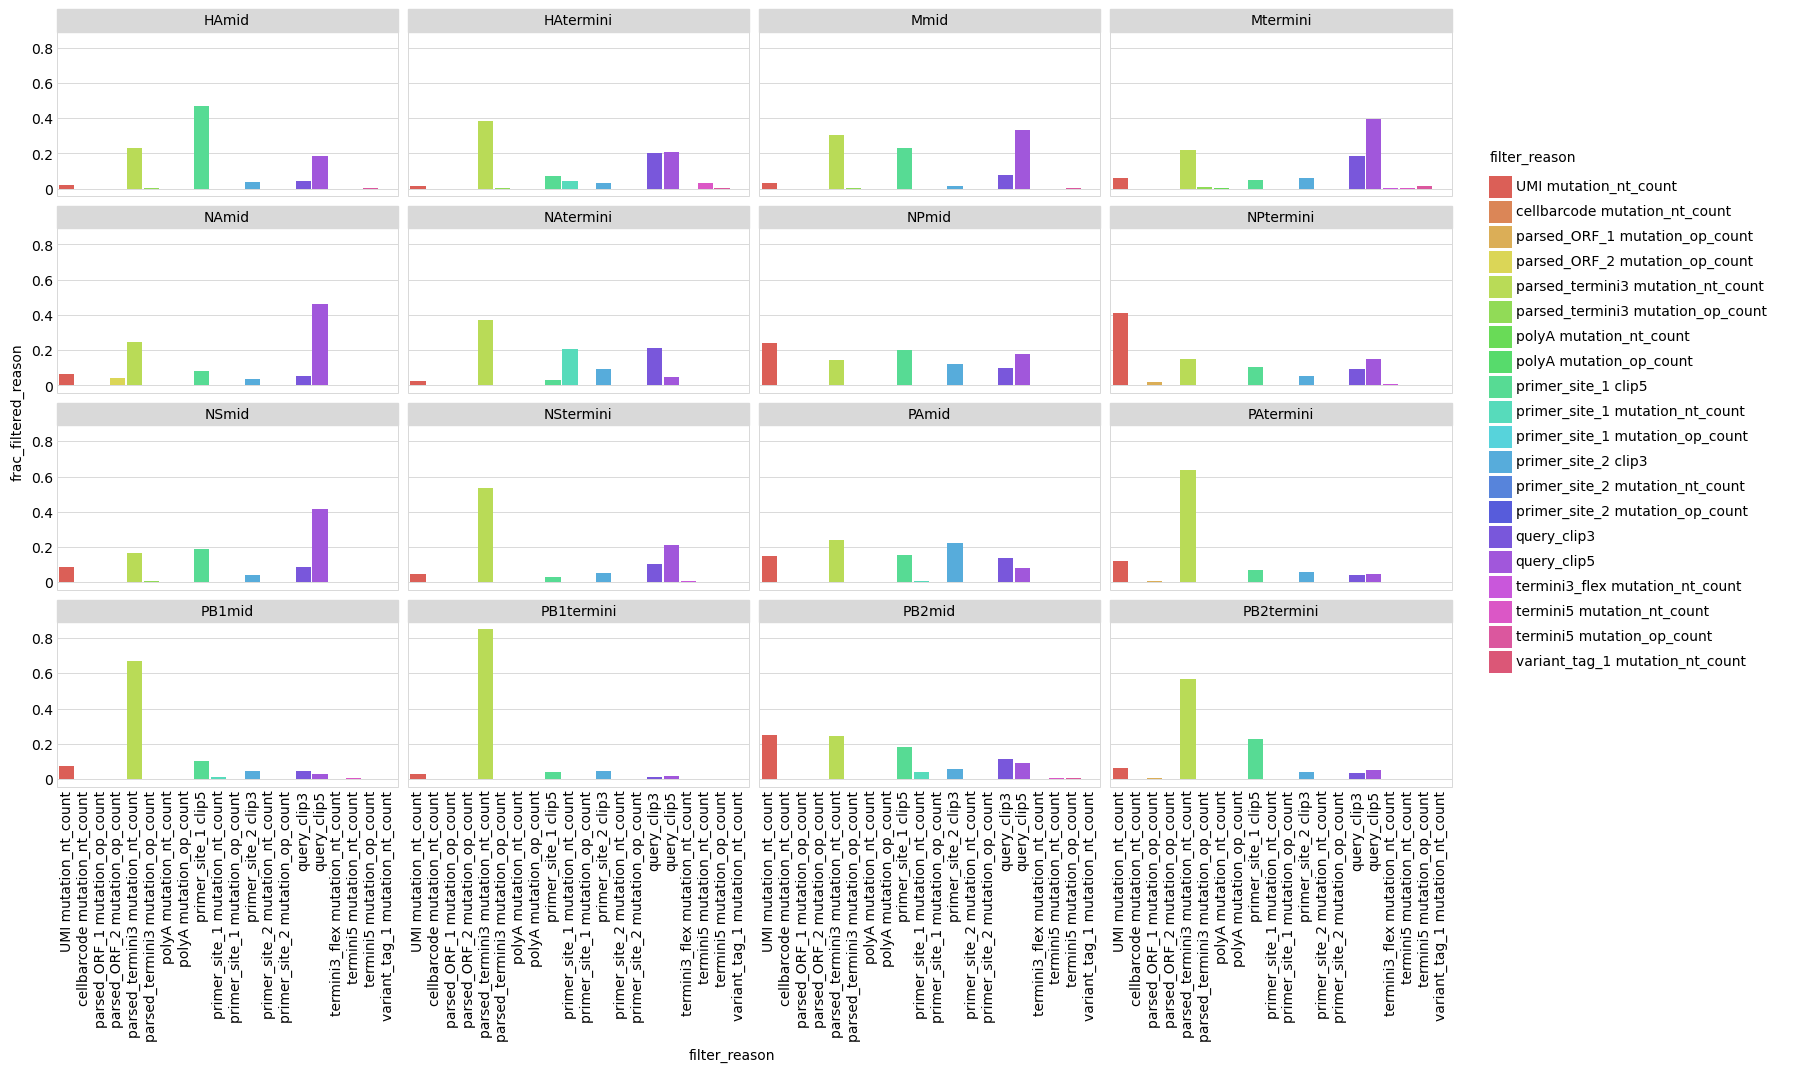

In [50]:
p = (
    p9.ggplot(ff_counts_df, p9.aes(x='filter_reason',
                                   y='frac_filtered_reason',
                                   fill='filter_reason'))
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('~ gene', ncol=4)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               figure_size=(18, 10),
               panel_grid_major_x=p9.element_blank(),
               )
    )
_ = p.draw()

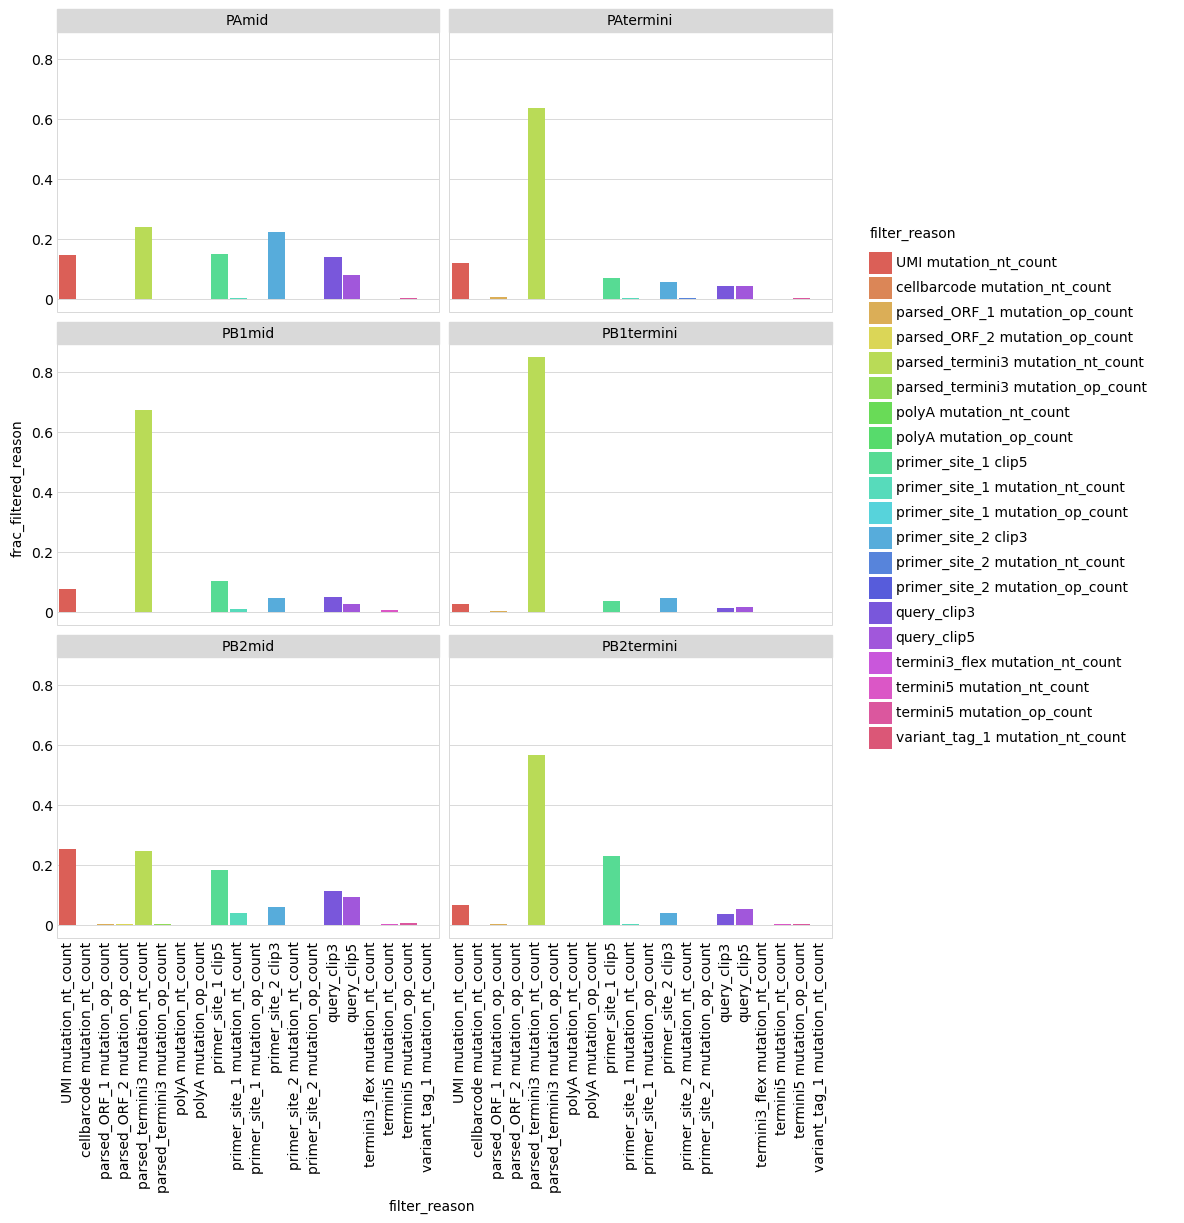

In [52]:
p = (
    p9.ggplot(ff_counts_df
              .query('gene == "PB2mid" or gene == "PB2termini" '
                     'or gene == "PB1mid" or gene == "PB1termini" '
                     'or gene == "PAmid" or gene == "PAtermini"'),
                      p9.aes(x='filter_reason',
                                   y='frac_filtered_reason',
                                   fill='filter_reason'))
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('~ gene', ncol=2)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               figure_size=(10, 12),
               panel_grid_major_x=p9.element_blank(),
               )
    )
_ = p.draw()

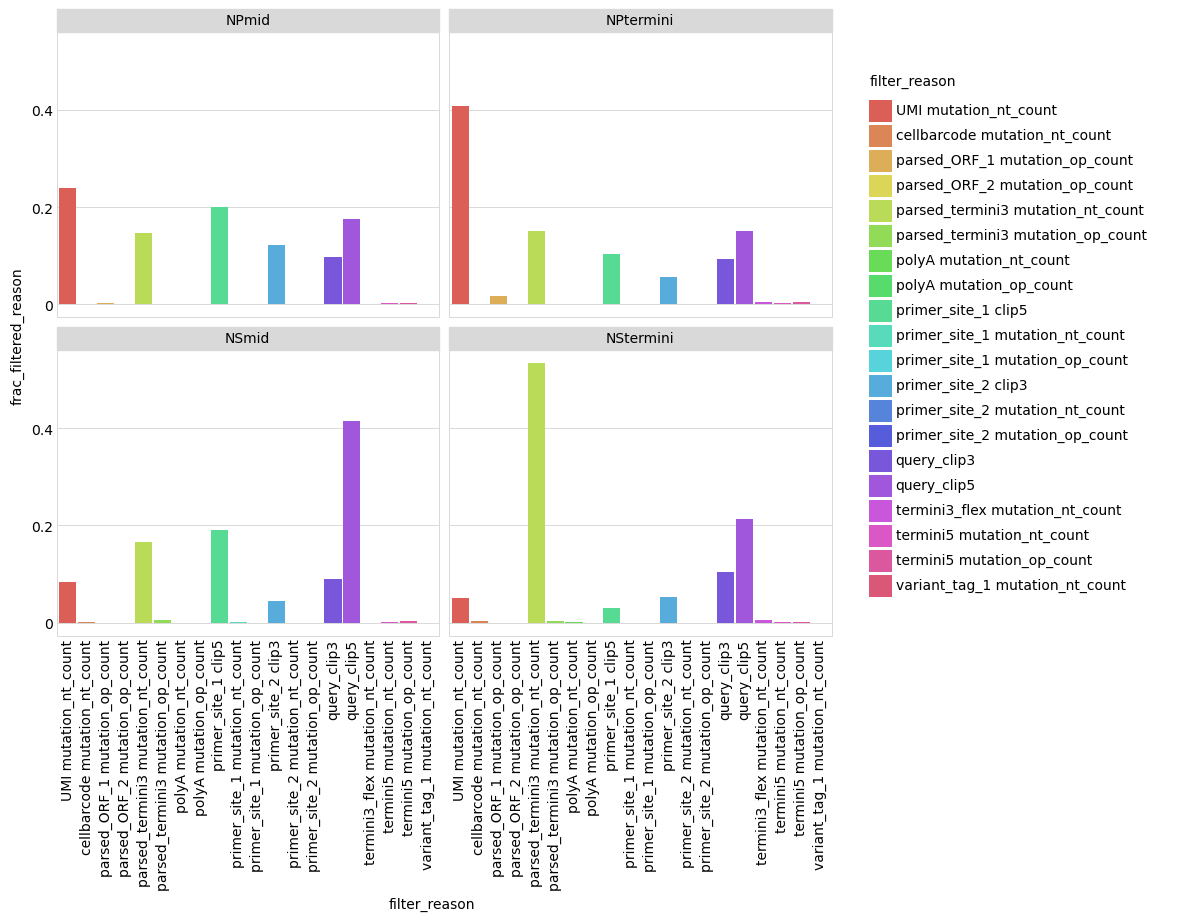

In [53]:
p = (
    p9.ggplot(ff_counts_df
              .query('gene == "NPmid" or gene == "NPtermini" '
                     'or gene == "NSmid" or gene == "NStermini"'),
                      p9.aes(x='filter_reason',
                                   y='frac_filtered_reason',
                                   fill='filter_reason'))
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('~ gene', ncol=2)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               figure_size=(10, 8),
               panel_grid_major_x=p9.element_blank(),
               )
    )
_ = p.draw()

## Get all mutations in a common ORF numbering system
The above code has called mutations in key features.
Now we need to actually convert these into the ORF-based numbering scheme that we care about.

First, we read a CSV file that maps the numbering of sites in each feature to the ORF numbering:

In [ ]:
amplicon_to_reference = pd.read_csv(amplicon_to_reference_df)
amplicon_to_reference.head()

We extract the names of the features of interest from `amplicon_to_reference`.
The first four columns are `target`, `transcript`, `gene`, `wt_nt`, and `ORF_position` and are not relevant to features, so we will not include them. 

In [ ]:
column_names = amplicon_to_reference.columns.tolist()

assert amplicon_to_reference.columns.tolist()[:5] \
    == ['target', 'transcript', 'gene', 'wt_nt', 'ORF_position'], \
    amplicon_to_reference

parsed_features = column_names[5:]
print(parsed_features)

Here are the aligned files made by `targets.align_and_parse`.

In [ ]:
for aligned_files in aligned:
    print(aligned[aligned_files])

Here we read in each aligned transcript CSV file that was made by `targets.align_and_parse`.
Then we re-number the mutations from the feature-level numbering in that file to an ORF-specific numbering scheme.
Next, we combine all of the mutations from each feature into a single column (`all_mutations_orf_numbered`) that gives all mutations in that CCS, and also add the names of the flu genes and transcripts.
Then we write the resulting data frame of mutations to a CSV.

In [ ]:
orf_numbered_alignments = pd.DataFrame()

for target, alignments_csv in aligned.items():
    
    # Load alignments
    alignments = pd.read_csv(alignments_csv, na_filter=False)
    
    print(f"Analyzing {len(alignments)} aligned CCSs for {target}")
    
    # Intersection of parsed_features and this targets' features
    t = targets.get_target(target)
    target_features = [f.name for f in t.features]
    output_features = [p for p in parsed_features if p in target_features]
    print(f"{target} has the following parsed features:")
    for p in output_features:
        print(p)
    print('\n')
    
    for feature in output_features:
        number_mapping = (
                amplicon_to_reference
                .query('target == @target')
                .query(f"{feature}.notnull()", engine='python')
                .assign(feature_num=lambda x: x[feature].astype(int))
                )
        print(f"Map for {feature}:")
        print(number_mapping)

        renumberer = alignparse.utils.MutationRenumber(
                                      number_mapping=number_mapping,
                                      old_num_col='feature_num',
                                      new_num_col='ORF_position',
                                      wt_nt_col='wt_nt',
                                      err_suffix=f" for {feature} in {target}",
                                      )

        alignments[f"{feature}_mutations_orf_numbered"] = (
                    alignments[f"{feature}_mutations"]
                    .map(renumberer.renumber_muts)
                    )

    alignments['target'] = target
    # aggregate mutations across all features to get all mutations in ORF
    alignments = (
    alignments.assign(all_mutations_orf_numbered=lambda x: x.apply(
                    lambda row: alignparse.utils.sort_mutations([
                            row[f"{feature}_mutations_orf_numbered"]
                            for feature in output_features
                            ]),
                    axis=1,
                    )
            )
    # merge in the viral trandcript and gene names
    .merge(amplicon_to_reference[['target', 'gene',
                                  'transcript']].drop_duplicates(),
           how='left', on='target')
    )
    orf_numbered_alignments = orf_numbered_alignments.append(alignments)



assert orf_numbered_alignments['gene'].notnull().all()

print(f"\nWriting ORF-numbered alignments to {mutation_df}")
orf_numbered_alignments.to_csv(mutation_df, index=False, compression='gzip',)